<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Computation-THEN-plot" data-toc-modified-id="Computation-THEN-plot-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Computation THEN plot</a></span><ul class="toc-item"><li><span><a href="#Concept-back-forth---circles" data-toc-modified-id="Concept-back-forth---circles-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Concept back forth - circles</a></span></li><li><span><a href="#back-forth-covar" data-toc-modified-id="back-forth-covar-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>back-forth covar</a></span></li><li><span><a href="#sine1-short" data-toc-modified-id="sine1-short-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>sine1 short</a></span></li><li><span><a href="#sine2-short" data-toc-modified-id="sine2-short-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>sine2 short</a></span></li><li><span><a href="#stagger-short" data-toc-modified-id="stagger-short-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>stagger short</a></span></li><li><span><a href="#HERE" data-toc-modified-id="HERE-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>HERE</a></span></li></ul></li></ul></div>

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

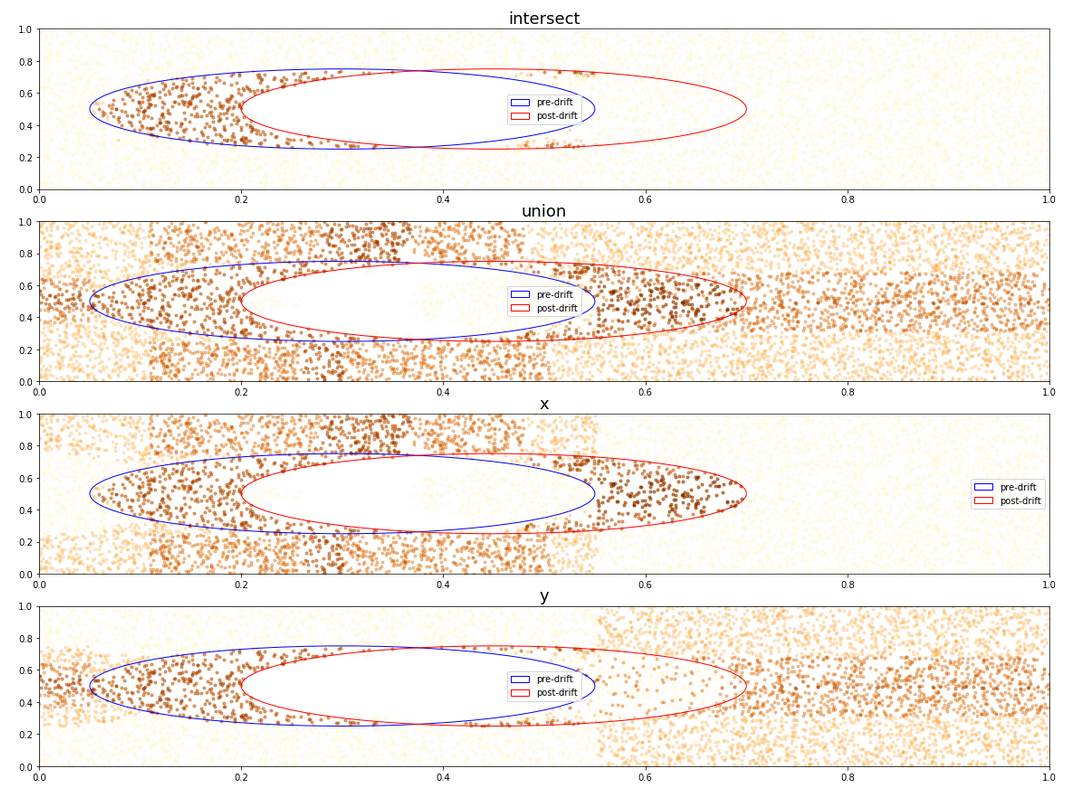


In [3]:
from drift_generators import *
from time import gmtime, strftime
import os
import pickle
from os import listdir
from os.path import isfile, join

2021-10-19 18:11:14.976343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 18:11:14.976363: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
D_G = Drift_generators(n_samples = int(4000), n_features = 2)
#drift
D_G.back_and_forth_abrupt_drift()
#retrainning
error, detection_indices, shap_vals = D_G.retrain_shap_adwin_back_best(return_shap = True)

In [5]:
#D_G.plot_retrain()

In [6]:
D_G = Drift_generators(n_samples = int(4000), n_features = 2)
D_G.back_and_forth_abrupt_drift()
#retrainning
error, detection_indices, shap_vals = D_G.retrain_shap_adwin_back_best(return_shap = True)

In [7]:
funcs = [func for func in dir(Drift_generators) if callable(getattr(Drift_generators, func))
         and not func.startswith("__")
         and "retrain" in func and not "plot" in func and not "perf" in func]
funcs = ["retrain_shap_adwin"]+[x for x in funcs if "back" in x]
funcs

['retrain_shap_adwin',
 'retrain_shap_adwin_back_best',
 'retrain_shap_adwin_back_train',
 'retrain_shap_adwin_back_worse',
 'retrain_shap_adwin_smallback']

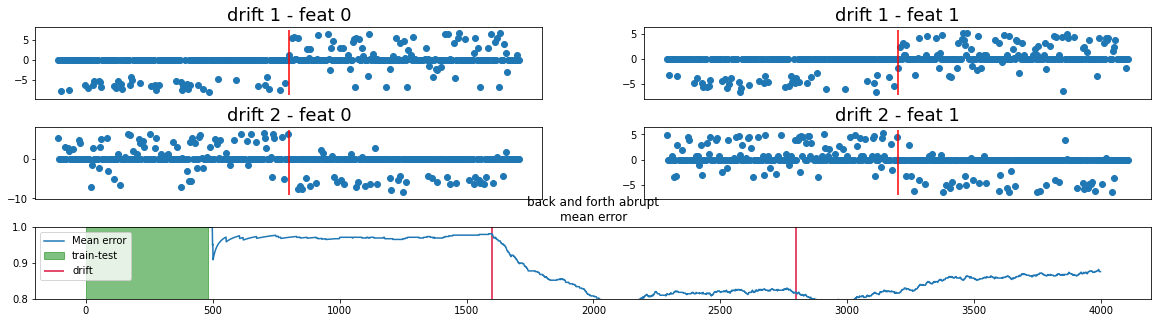

In [8]:
#shap_vals = all_shap_vals[0]
w = 400 #width

fig, ax = plt.subplots(nrows = len(D_G.drift_points)+1, ncols = D_G.n_features, figsize = [20,5])

for d, d_point in enumerate(D_G.drift_points):
    for feat in range(D_G.n_features):
        ax[d,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
               shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat])
        ymin,ymax = ax[d,feat].get_ylim()
        ax[d,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
        ax[d,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
        ax[d,feat].set_xticks([])

#wide plot
gs = ax[2, 0].get_gridspec()
for a in ax[2,:]: a.remove()
axbig = fig.add_subplot(gs[2, :])

D_G.plot_retrain(ax = axbig)
axbig.set_ylim(ymin = 0.8, ymax = 1)
plt.subplots_adjust(hspace = 0.4)

In [9]:
funcs = ['retrain_shap_adwin_back_train',
         'retrain_shap_adwin_smallback',
         'retrain_shap_adwin_back_worse',
         'retrain_shap_adwin_back_best',
         'retrain_shap_adwin']

# Computation THEN plot
## Concept back forth - circles

In [10]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

D_G = Drift_generators(n_samples = int(4000), n_features = 3)
D_G.back_and_forth_abrupt_drift()
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_train
     shap_adwin_smallback
     shap_adwin_back_worse
     shap_adwin_back_best
     shap_adwin
CPU times: user 6min 37s, sys: 226 ms, total: 6min 37s
Wall time: 53.1 s


CPU times: user 882 ms, sys: 8.04 ms, total: 890 ms
Wall time: 880 ms


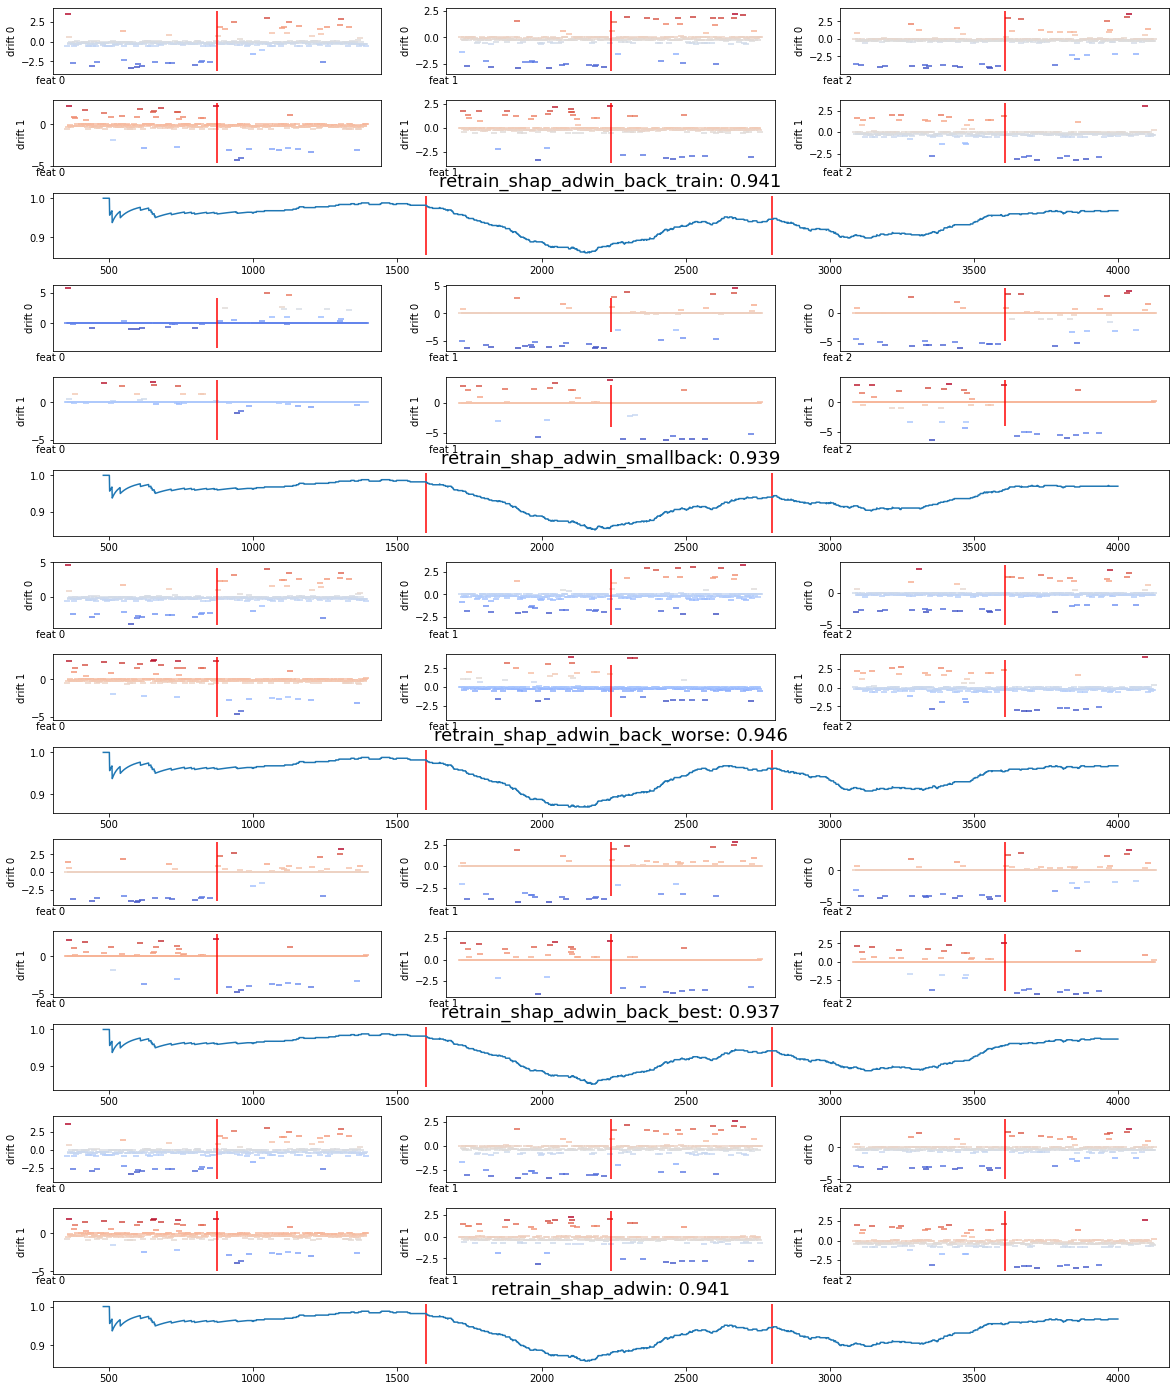

In [11]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

## back-forth covar
<div>
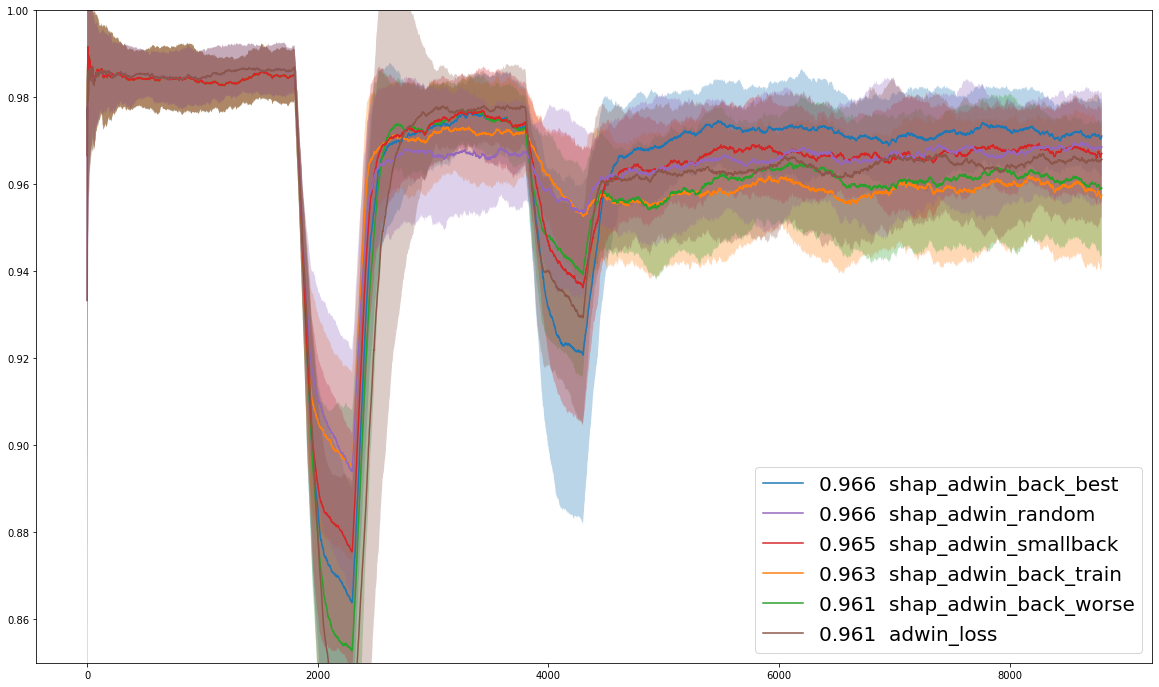
</div>


In [12]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

#D_G = Drift_generators(n_samples = int(4000), n_features = 3)
#D_G.back_and_forth_abrupt_drift()
D_G = Drift_generators(n_samples = int(4000), n_features = 3)
d_centers = [(0, 0, 0.3, 0.25, 1),(0, 0.3, 0.5, 0, 0.25),(0, 0.5, 1, 0.25, 1)]
D_G.brutal_covariate_drift(d_centers=d_centers)
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_train
     shap_adwin_smallback
     shap_adwin_back_worse
     shap_adwin_back_best
     shap_adwin
CPU times: user 6min 56s, sys: 378 ms, total: 6min 57s
Wall time: 56.7 s


CPU times: user 914 ms, sys: 4 ms, total: 918 ms
Wall time: 915 ms


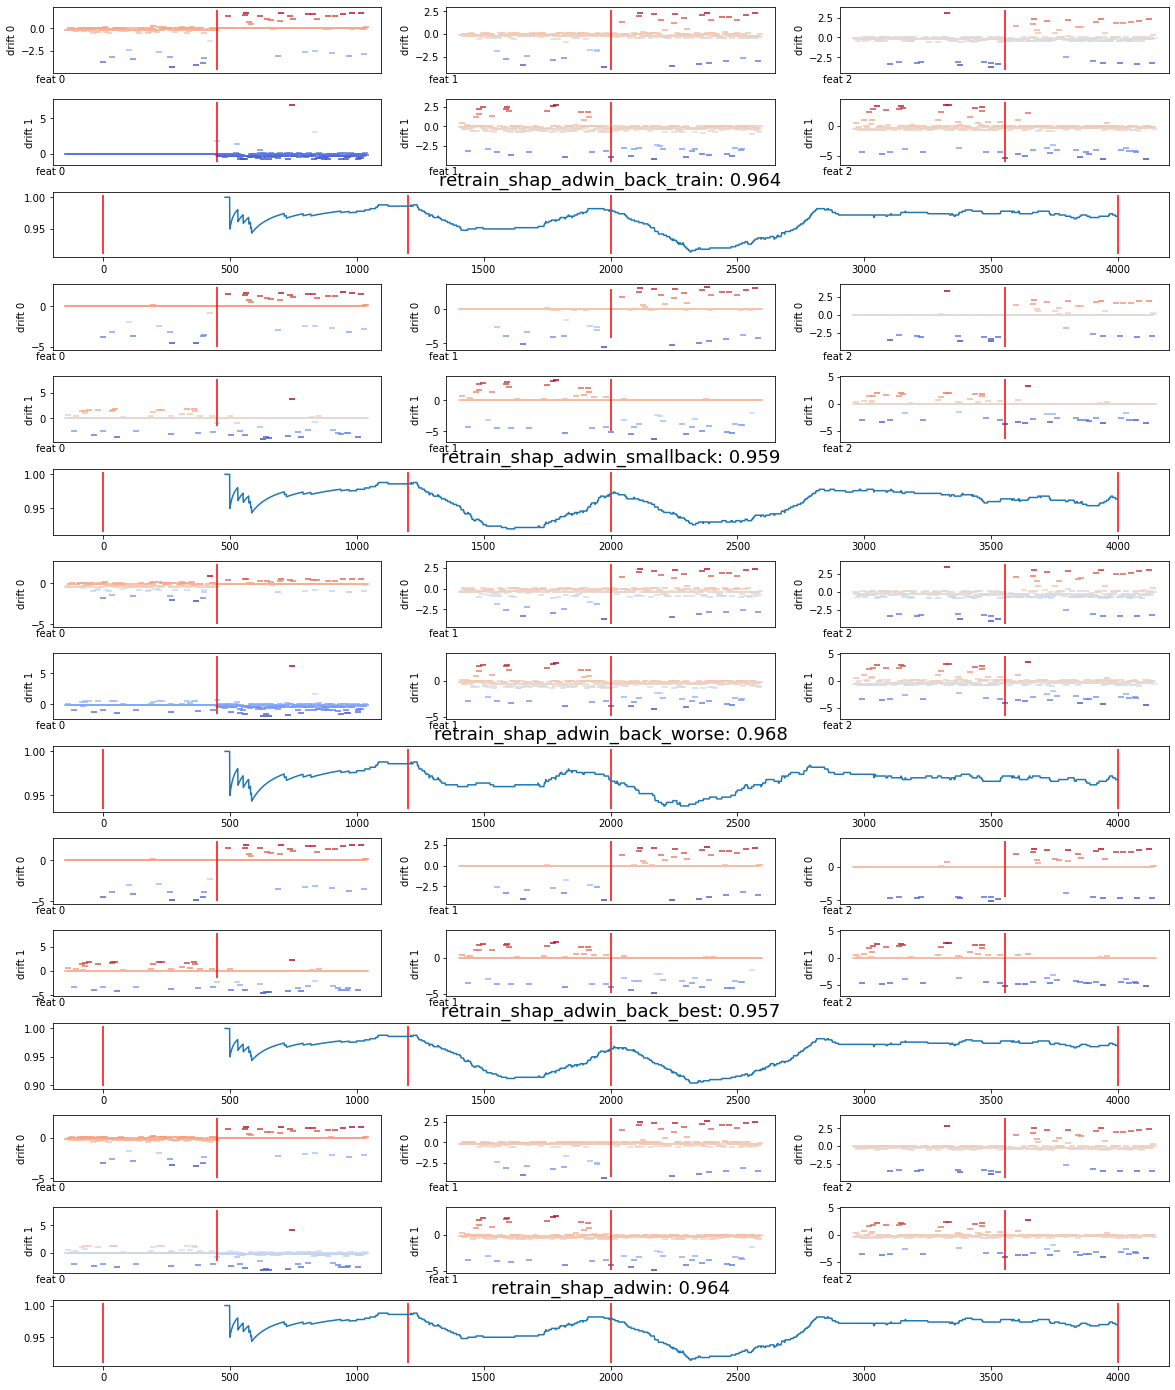

In [13]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

## sine1 short

In [14]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

D_G = Drift_generators()
D_G.load_df("sine1_short")
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_train
     shap_adwin_smallback
     shap_adwin_back_worse
     shap_adwin_back_best
     shap_adwin
CPU times: user 4min 37s, sys: 227 ms, total: 4min 37s
Wall time: 37.5 s


CPU times: user 527 ms, sys: 7.99 ms, total: 535 ms
Wall time: 531 ms


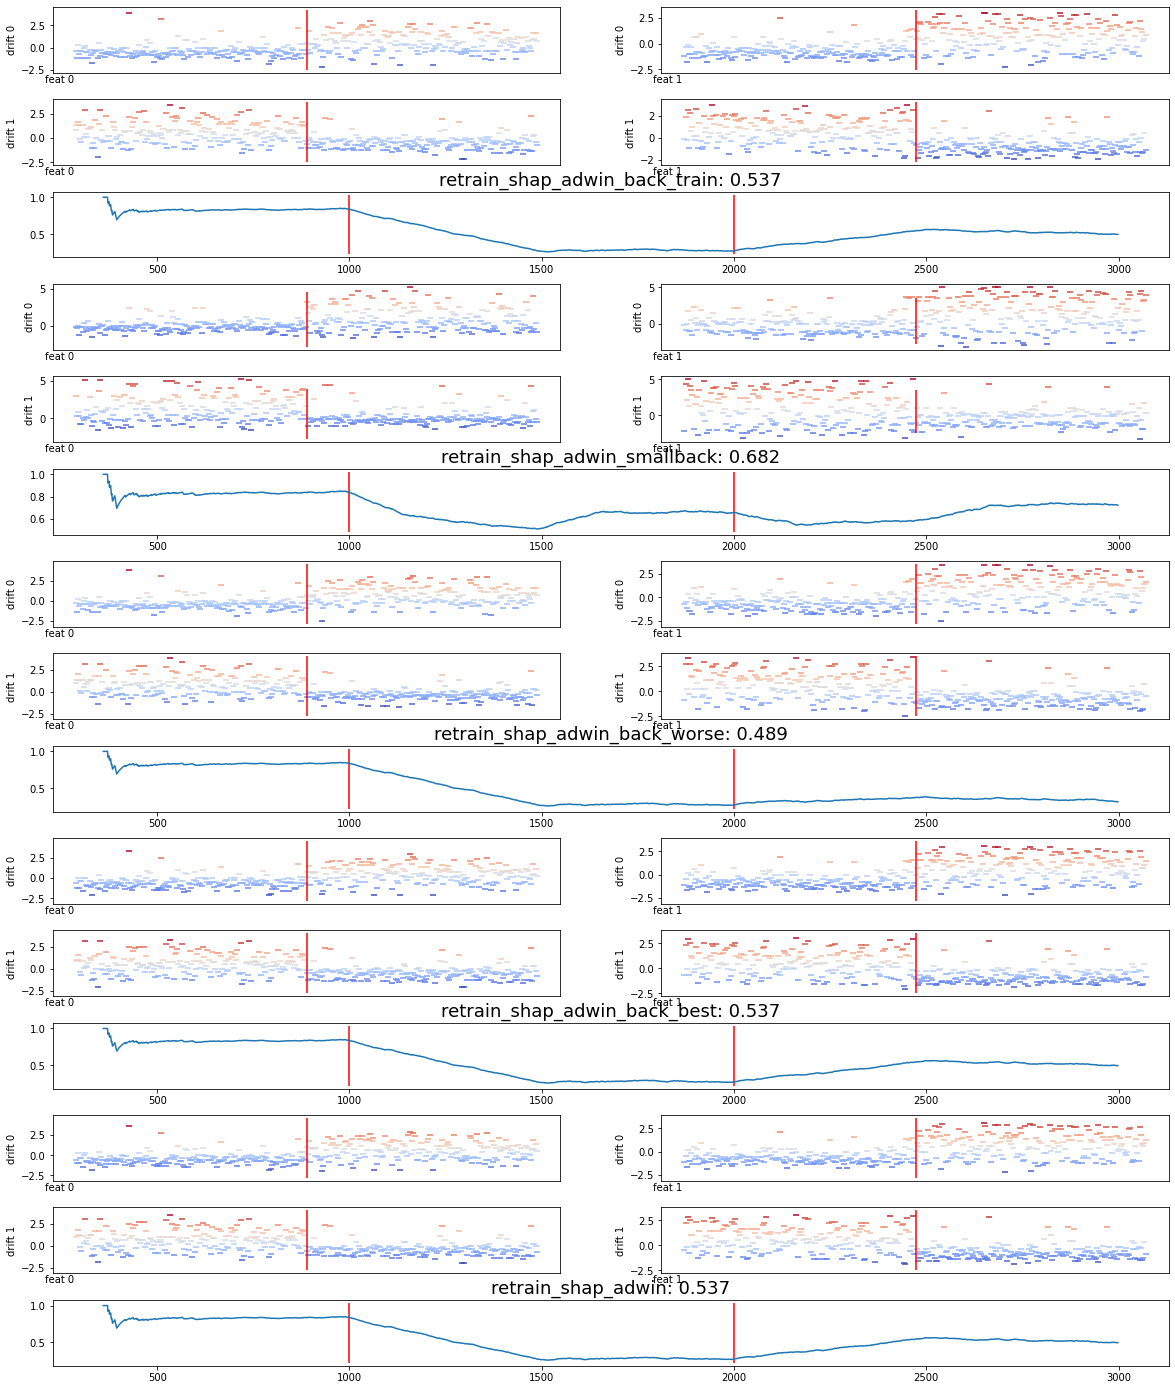

In [15]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

## sine2 short

In [16]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

D_G = Drift_generators()
D_G.load_df("sine2_short")
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_train
     shap_adwin_smallback
     shap_adwin_back_worse
     shap_adwin_back_best
     shap_adwin
CPU times: user 4min 36s, sys: 202 ms, total: 4min 36s
Wall time: 37.5 s


CPU times: user 779 ms, sys: 7.99 ms, total: 787 ms
Wall time: 781 ms


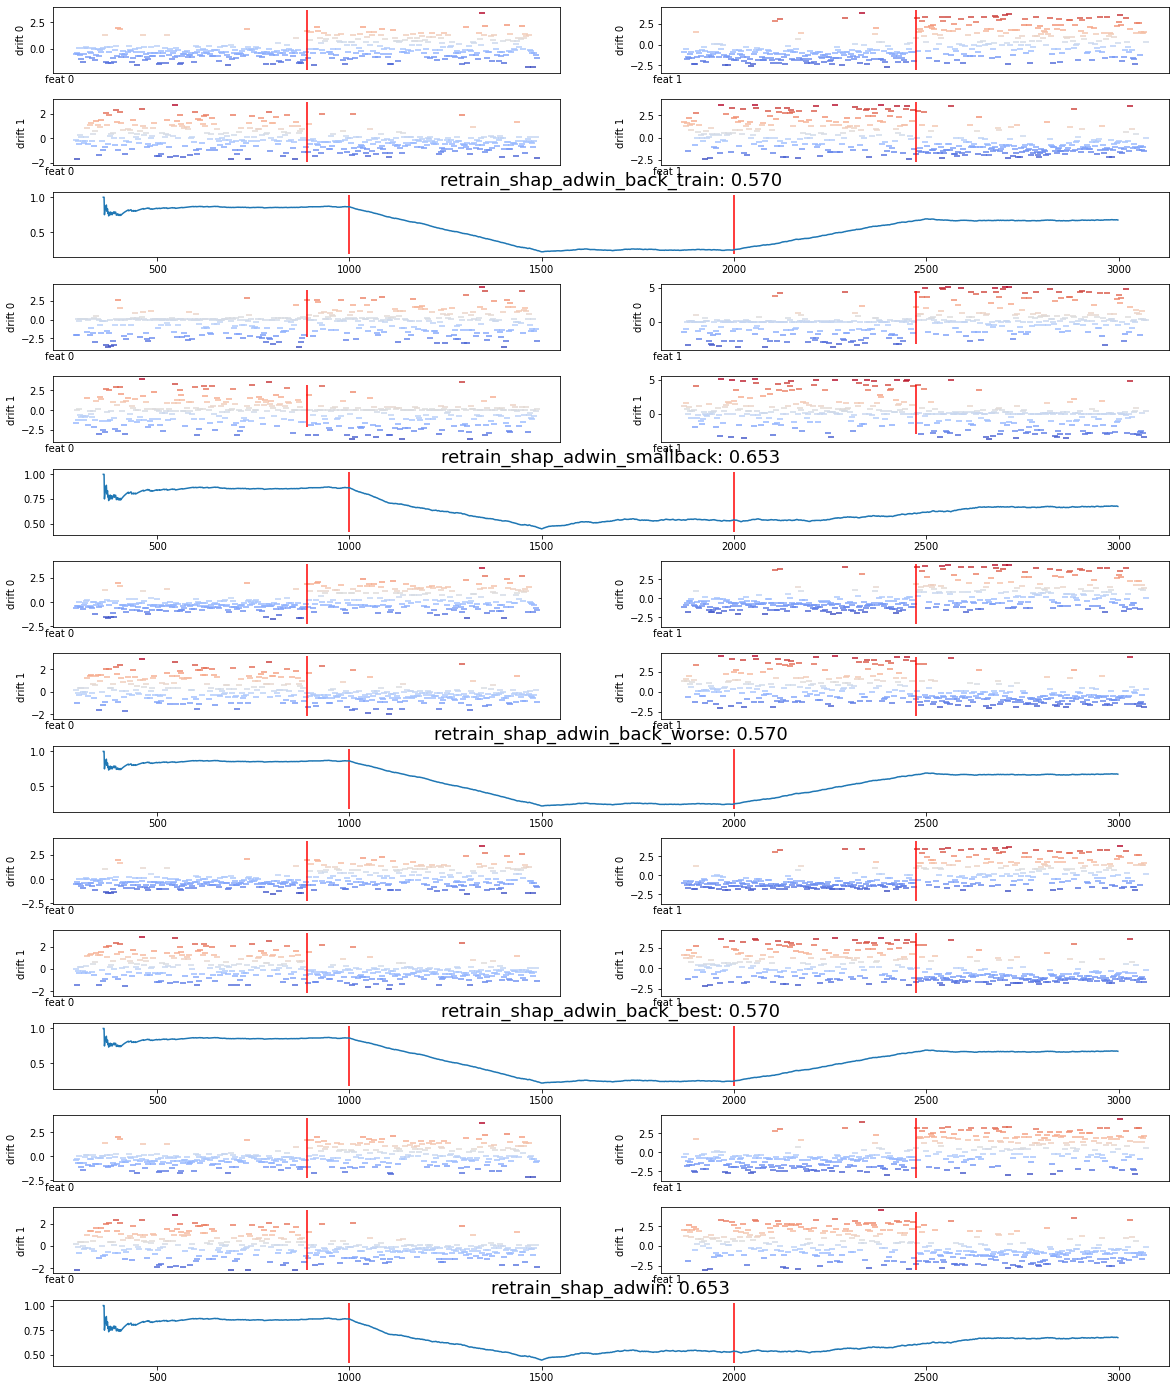

In [17]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

## stagger short

In [18]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

D_G = Drift_generators()
D_G.load_df("stagger_short")
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_train
     shap_adwin_smallback
     shap_adwin_back_worse
     shap_adwin_back_best
     shap_adwin
CPU times: user 7min 8s, sys: 367 ms, total: 7min 9s
Wall time: 57.1 s


CPU times: user 879 ms, sys: 4.01 ms, total: 883 ms
Wall time: 877 ms


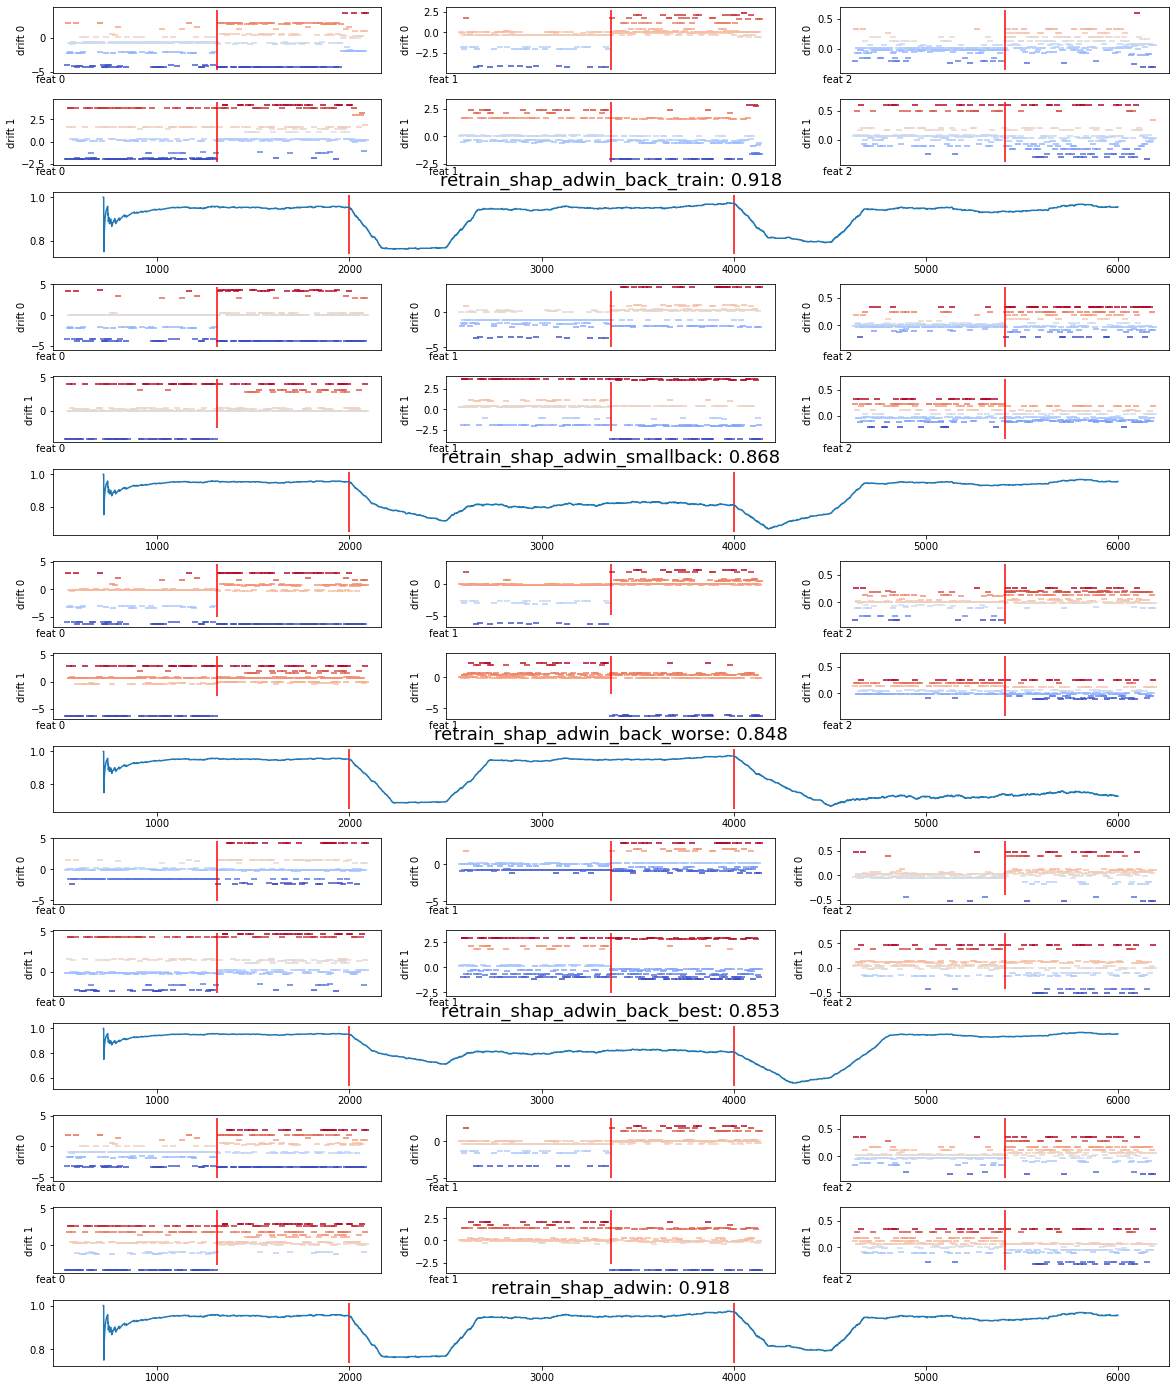

In [19]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

## HERE

In [20]:
from drift_generators import *

In [21]:
funcs = ['retrain_shap_adwin_back_worse',
         'retrain_shap_adwin_back_best']

In [22]:
D_G = Drift_generators(n_samples = int(7000), n_features = 3)
D_G.back_and_forth_abrupt_drift()
error_list, detections = D_G.load_data(funcs, dataset = "brutal_concept_backforth", n_load = 30)

['shap_adwin_back_worse', 'shap_adwin_back_best']

30 results loaded for each policy (2 funcs)


In [23]:
%%time
all_shap_vals = []
all_err_mean = []

w_size = 500

D_G = Drift_generators(n_samples = int(7000), n_features = 3)
D_G.back_and_forth_abrupt_drift()
for i, func in enumerate(funcs):
    print("    ",func[8:])
    error, detection_indices, shap_vals = getattr(Drift_generators, func)(D_G, return_shap = True)
    all_shap_vals.append(shap_vals)
    all_err_mean.append([np.mean(error[max(0,i-w_size):i]) for i in range(1,len(error))])

     shap_adwin_back_worse
     shap_adwin_back_best
CPU times: user 6min 15s, sys: 312 ms, total: 6min 15s
Wall time: 50.1 s


CPU times: user 327 ms, sys: 13 µs, total: 327 ms
Wall time: 319 ms


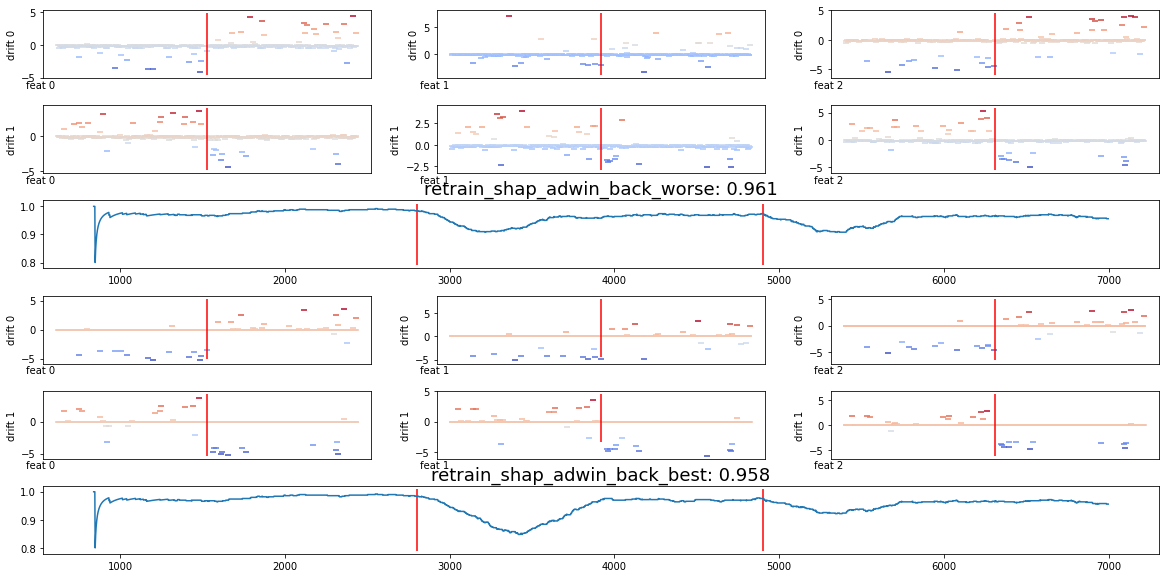

In [24]:
%%time
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs)*(len(drift_points)+1), ncols = D_G.n_features, figsize = [20,5*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    for d, d_point in enumerate(drift_points):
        for feat in range(D_G.n_features):
            drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]
            
            ax[d+i*3,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
                   drift_shap_vals, marker = "_", c = drift_shap_vals,cmap="coolwarm")
            
            ymin,ymax = ax[d,feat].get_ylim()
            ax[d+i*3,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
            #ax[d+i*3,feat].set_title("drift %d - feat %d"%(d+1, feat), fontsize = 18)
            ax[d+i*3,feat].set_xticks([])
            ax[d+i*3,feat].set_ylabel("drift %d"%(d))
            ax[d+i*3,feat].set_xlabel("feat %d            "%(feat))
            ax[d+i*3,feat].xaxis.set_label_coords(0.05, -0.025)

    #wide plot
    gs = ax[len(drift_points)+i*3, 0].get_gridspec()
    for a in ax[len(drift_points)+i*3,:]: a.remove()
    axbig = fig.add_subplot(gs[len(drift_points)+i*3, :])
    
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
    ymin, ymax = axbig.get_ylim()
    for d, d_point in enumerate(D_G.drift_points):
        axbig.vlines(ymin=ymin, ymax=ymax, x = d_point, color = 'red',alpha = 1)
        

plt.subplots_adjust(hspace = 0.4)

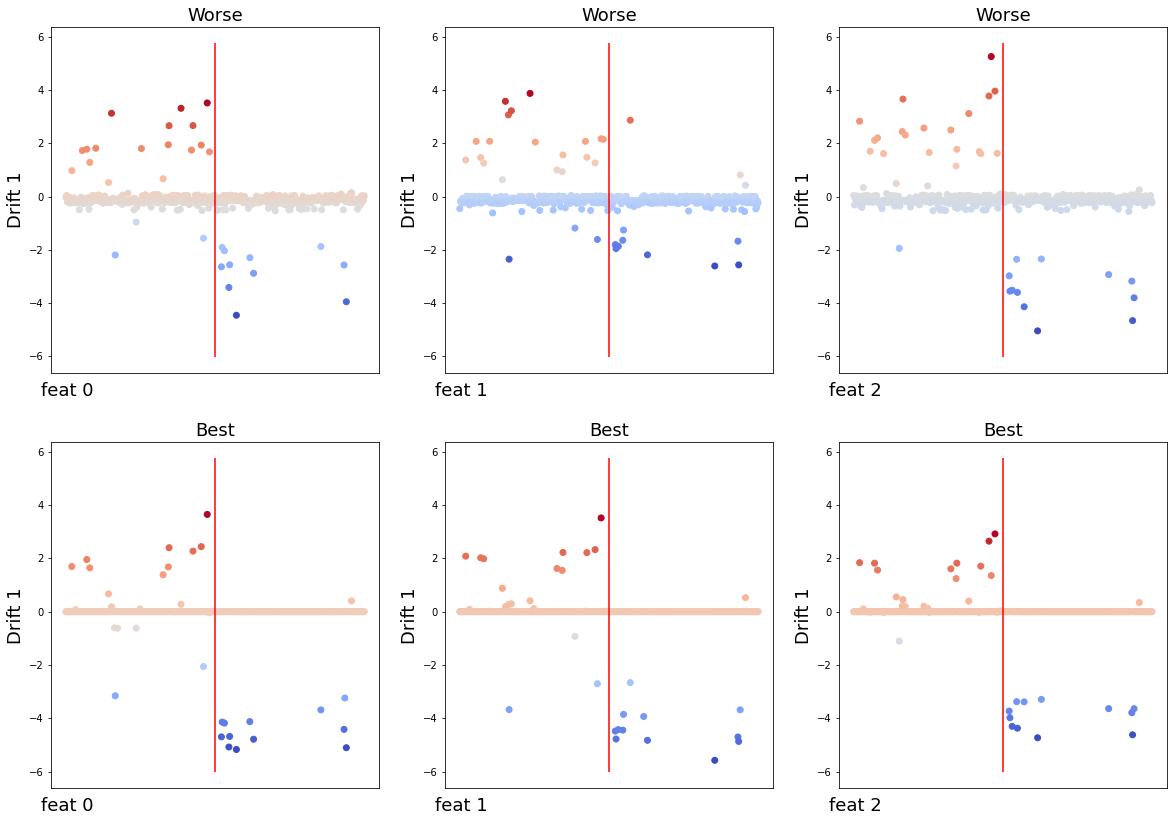

In [25]:
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = len(funcs), ncols = D_G.n_features, figsize = [20,7*len(funcs)])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    d = 1
    d_p = drift_points[0]
#    for d, d_point in enumerate(drift_points):
    for feat in range(D_G.n_features):
        drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]

        ax[i,feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
               drift_shap_vals, marker = "o", c = drift_shap_vals,cmap="coolwarm")

        ax[i,feat].set_xticks([])
        ax[i,feat].set_ylabel("Drift %d"%(d), fontsize = 18)
        ax[i,feat].set_xlabel("feat %d"%(feat), fontsize = 18)
        ax[i,feat].xaxis.set_label_coords(0.05, -0.025)
        
        
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
     

ymin = min([ax[i,feat].get_ylim()[0] for i in range(2) for feat in range(D_G.n_features)])
ymax = max([ax[i,feat].get_ylim()[1] for i in range(2) for feat in range(D_G.n_features)])

for i, func in enumerate(funcs):
    for feat in range(D_G.n_features):
        ax[i,feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
        if(i==0):ax[i,feat].set_title("Worse", fontsize =18)
        if(i==1):ax[i,feat].set_title("Best", fontsize =18)
        

plt.subplots_adjust(hspace = 0.2)

plt.show()

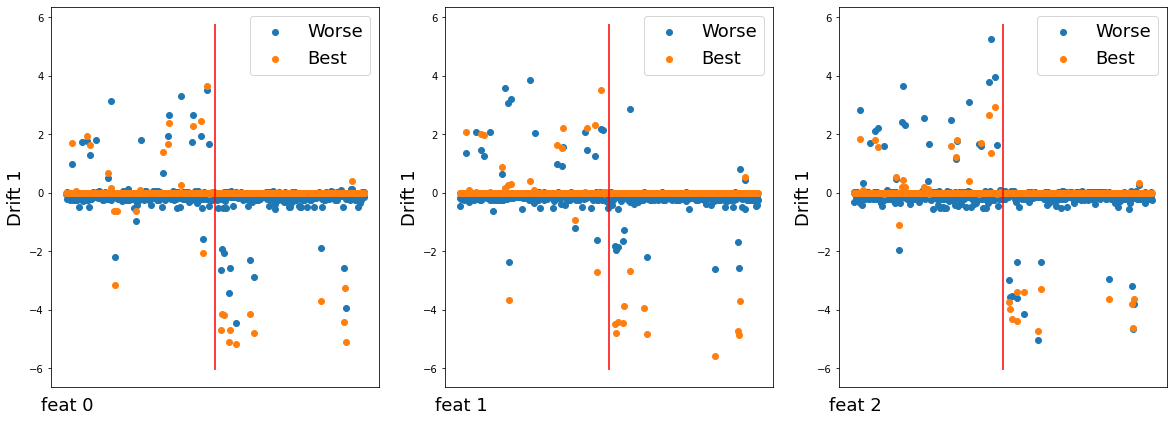

In [26]:
w = 400 #width
drift_points = [d_point for d, d_point in enumerate(D_G.drift_points) if D_G.n>d_point > D_G.n_seen()]

fig, ax = plt.subplots(nrows = 1, ncols = D_G.n_features, figsize = [20,7])

for i, func in enumerate(funcs):
    shap_vals = all_shap_vals[i]
    d = 1
    d_p = drift_points[0]
#    for d, d_point in enumerate(drift_points):
    for feat in range(D_G.n_features):
        drift_shap_vals = shap_vals[d_point-int(w/2)-D_G.n_seen() : d_point+int(w/2)-D_G.n_seen(), feat]

        if(i==0): func = "Worse"
        if(i==1): func = "Best"
        ax[feat].scatter(np.arange(d_point-int(w/2) , d_point+int(w/2)),
               drift_shap_vals, marker = "o", label = func)#, c = drift_shap_vals)

        ax[feat].set_xticks([])
        ax[feat].set_ylabel("Drift %d"%(d), fontsize = 18)
        ax[feat].set_xlabel("feat %d"%(feat), fontsize = 18)
        ax[feat].xaxis.set_label_coords(0.05, -0.025)
        
    err_mean = all_err_mean[i]
    axbig.set_title(func+": %.3f"%np.mean(err_mean), fontsize = 18)
    n_seen = D_G.n_seen()
    axbig.plot(np.arange(n_seen, n_seen + len(err_mean)), err_mean)
     

ymin = min([ax[feat].get_ylim()[0] for i in range(2) for feat in range(D_G.n_features)])
ymax = max([ax[feat].get_ylim()[1] for i in range(2) for feat in range(D_G.n_features)])

for feat in range(D_G.n_features):
    ax[feat].vlines(ymin=ymin, ymax=ymax, x=d_point, color = "red")
    ax[feat].legend(fontsize = 18)


plt.subplots_adjust(hspace = 0.2)

plt.show()